# Supervisor
https://langchain-ai.github.io/langgraph/tutorials/multi_agent/agent_supervisor/ \
https://langchain-ai.github.io/langgraph/concepts/multi_agent/#supervisor


In [2]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

tavily_tool = TavilySearchResults(max_results=5)

# This executes code locally, which can be unsafe
repl = PythonREPL()


@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code and do math. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    # result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return result_str

In [3]:
from typing import Literal
from typing_extensions import TypedDict

# from langchain_anthropic import ChatAnthropic
from utils.aiutils import  get_chatmodel
from langgraph.graph import MessagesState
from langgraph.types import Command


members = ["researcher", "coder"]
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = members + ["FINISH"]

system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)


class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal[*options]


# llm = ChatAnthropic(model="claude-3-5-sonnet-latest")
llm = get_chatmodel()


def supervisor_node(state: MessagesState) -> Command[Literal[*members, "__end__"]]:
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]
    response = llm.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    if goto == "FINISH":
        goto = END

    return Command(goto=goto)

2024-12-12 11:02:32.243 | DEBUG    | utils.aiutils:get_chatmodel:92 - Using Azure...


In [4]:
from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import create_react_agent


research_agent = create_react_agent(
    llm, tools=[tavily_tool], state_modifier="You are a researcher. DO NOT do any math."
)


def research_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    result = research_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="researcher")
            ]
        },
        goto="supervisor",
    )


# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION, WHICH CAN BE UNSAFE WHEN NOT SANDBOXED
code_agent = create_react_agent(llm, tools=[python_repl_tool])


def code_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    result = code_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="coder")
            ]
        },
        goto="supervisor",
    )


builder = StateGraph(MessagesState)
builder.add_edge(START, "supervisor")
builder.add_node("supervisor", supervisor_node)
builder.add_node("researcher", research_node)
builder.add_node("coder", code_node)
graph = builder.compile()

## Diagramm

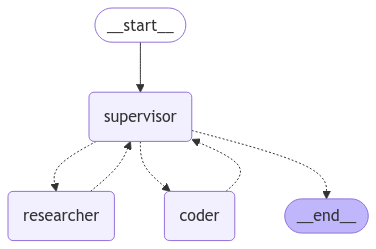

In [5]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

## Test 1

In [ ]:
for s in graph.stream(
    {"messages": [("user", "What's the square root of 42?")]}, subgraphs=True
):
    print(s)
    print("----")

((), {'supervisor': None})
----
(('researcher:2d7bfca3-88d0-e640-af4e-81b1d701762f',), {'agent': {'messages': [AIMessage(content="I can't perform calculations, but I can help you find the square root of 42 using a calculator or provide information about it. Would you like me to do that?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 35, 'prompt_tokens': 98, 'total_tokens': 133, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'gpt-4o-mini', 'system_fingerprint': 'fp_04751d0b65', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {'hate': {'filtered': False, 's

Python REPL can execute arbitrary code. Use with caution.


(('coder:1e3b02f3-2e1c-dec1-e31e-92ccb1888e69',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_d0OgLoWBhHtKX0B4royQr1pS', 'function': {'arguments': '{"code":"import math\\nmath.sqrt(42)"}', 'name': 'python_repl_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 137, 'total_tokens': 160, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'gpt-4o-mini', 'system_fingerprint': 'fp_04751d0b65', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'tool_calls', 'logprobs': None, 'content_filter_results': {}}, id='run-d1c286e7-c455-47f5-bfd0-8477aa9

## Test 2

In [6]:
for s in graph.stream(
    {
        "messages": [
            (
                "user",
                "Find the latest GDP of New York and California, then calculate the average",
            )
        ]
    },
    subgraphs=True,
):
    print(s)
    print("----")

((), {'supervisor': None})
----
(('researcher:cb9fc92d-7504-9f05-ae09-1d14dfb230ee',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_FmxlN8QEupxtFqeiucrqidOx', 'function': {'arguments': '{"query": "latest GDP of New York 2023"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_Ej1HEjTgJ3B7WVFsdAsFc2aj', 'function': {'arguments': '{"query": "latest GDP of California 2023"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 65, 'prompt_tokens': 104, 'total_tokens': 169, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'gpt-4o-mini', 'system_fingerprint': 'fp_04751d0b65', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexu

Python REPL can execute arbitrary code. Use with caution.


(('coder:bd3ec52e-d875-6200-1d45-e63bfe168a04',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_P7nUuBT2yVMYDWoo2PMW04VL', 'function': {'arguments': '{"code":"new_york_gdp = 2.0e12  # in dollars\\ncalifornia_gdp = 3.87e12  # in dollars\\naverage_gdp = (new_york_gdp + california_gdp) / 2\\naverage_gdp"}', 'name': 'python_repl_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 70, 'prompt_tokens': 244, 'total_tokens': 314, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'gpt-4o-mini', 'system_fingerprint': 'fp_04751d0b65', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'fin